<a href="https://colab.research.google.com/github/strangest-quark/line_item_extraction/blob/master/Line_Item_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank statements Line Item Extraction
Based on Cascade TableNet - https://github.com/DevashishPrasad/CascadeTabNet 

## 1. Install all the prerequisite
This will take a while, Remember to **Restart Runtime** after this step is done 

In [ ]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q mmcv terminaltables
!git clone --branch v1.2.0 'https://github.com/open-mmlab/mmdetection.git'
%cd "mmdetection"
!pip install -r "/content/mmdetection/requirements/optional.txt"
!python setup.py install
!python setup.py develop
!pip install -r {"requirements.txt"}
!pip install pillow==6.2.1 
!pip install mmcv==0.4.3
%cd "/content"

## 2. Clone the Repository 

In [ ]:
!git clone https://github.com/strangest-quark/line_item_extraction.git

## 3. Download the Pretrained Model



In [ ]:
!gdown "https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT"

## 4. Run the Predictions

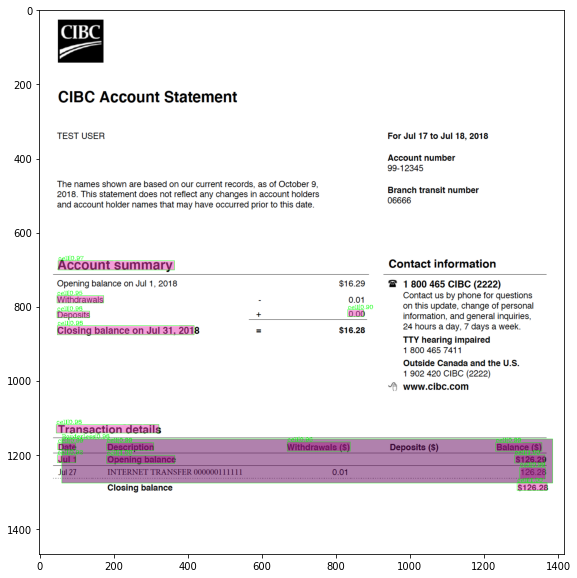

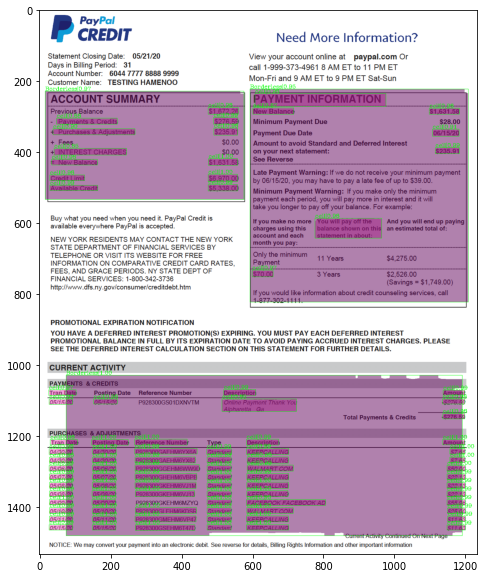

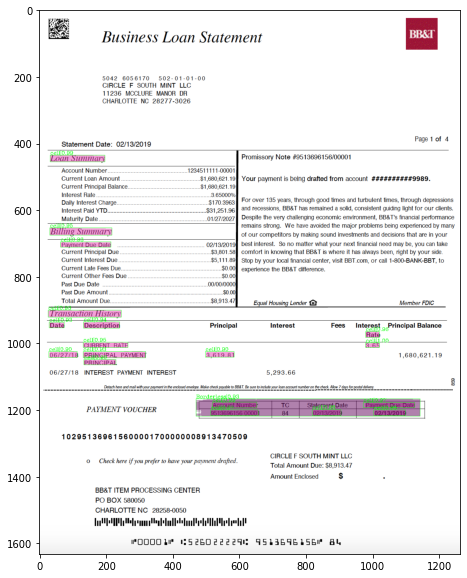

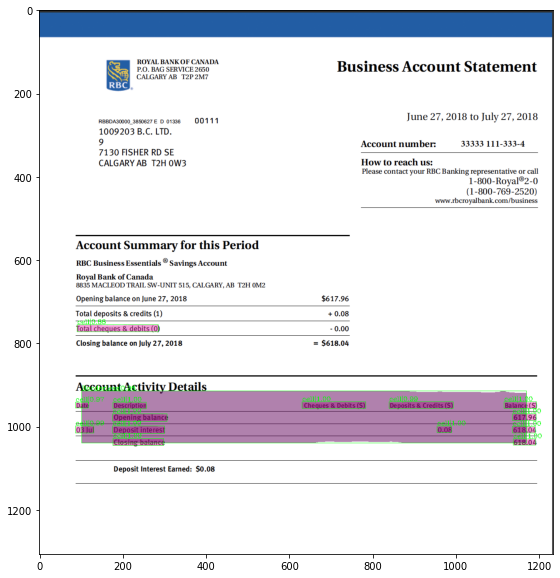

In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import os

# Load model
config_file = '/content/line_item_extraction/config/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
checkpoint_file = '/content/epoch_36.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')

directory = '/content/line_item_extraction/sample docs'

results = []

for filename in os.listdir(directory):
    if filename.endswith(".png"):
      # Run Inference
      results.append(inference_detector(model, directory+'/'+filename))

      # Visualization results
      show_result_pyplot(directory+'/'+filename, results[-1],('Bordered', 'cell', 'Borderless'), score_thr=0.85)

After this, use TSR postprocessing for best result

In [2]:
%cd "/content"
from line_item_extraction.border_main import border
import lxml.etree as etree
import cv2
from google.colab.patches import cv2_imshow
from mmdet.apis import inference_detector, show_result, init_detector
import glob
from line_item_extraction.cell_text import borderless

result = results[0]

image_path = '/content/line_item_extraction/sample docs/'
xmlPath = '/content/line_item_extraction/cells xml/'

config_fname = "/content/line_item_extraction/config/cascade_mask_rcnn_hrnetv2p_w32_20e.py" 
checkpoint_path = "/content/"
epoch = 'epoch_36.pth'

model = init_detector(config_fname, checkpoint_path+epoch)

imgs=[]

# List of images in the image_path
for filename in os.listdir(image_path):
    if filename.endswith(".png"):
      imgs.append(image_path+filename)
print(imgs)
for i in imgs:
  for i in imgs:
    try:
      result = inference_detector(model, i)
      res_border = []
      res_bless = []
      res_cell = []
      root = etree.Element("document")
      ## for border
      for r in result[0][0]:
        if r[4] > .85:
            res_border.append(r[:4].astype(int))
      ## for cells
      for r in result[0][1]:
          if r[4] > .85:
              r[4] = r[4] * 100
              res_cell.append(r.astype(int))
      ## for borderless
      for r in result[0][2]:
          if r[4] > .85:
              res_bless.append(r[:4].astype(int))

      ## if border tables detected
      if len(res_border) != 0:
          ## call border script for each table in image
          for res in res_border:
              try:
                  root.append(border(res, cv2.imread(i)))
              except:
                  pass
      if len(res_bless) != 0:
          if len(res_cell) != 0:
              for no, res in enumerate(res_bless):
                  root.append(borderless(res, cv2.imread(i), res_cell))
      myfile = open(xmlPath + i.split('/')[-1][:-3] + 'xml', "w")
      myfile.write('<?xml version="1.0" encoding="UTF-8"?>\n')
      myfile.write(etree.tostring(root, pretty_print=True, encoding="unicode"))
      myfile.close()
    except:
      print("Error")

/content
['/content/line_item_extraction/sample docs/cibc.png', '/content/line_item_extraction/sample docs/paypal.png', '/content/line_item_extraction/sample docs/bbt.png', '/content/line_item_extraction/sample docs/rbc.png']
[array([  46, 1118,  323, 1141,   98])]
[array([  50, 1168,   98, 1186,   98]), array([ 182, 1167,  309, 1188,   99]), array([ 669, 1165,  839, 1190,   96]), array([1231, 1167, 1356, 1190,   98])]
[array([  49, 1200,   99, 1221,   92]), array([ 182, 1201,  366, 1223,   99]), array([1282, 1200, 1364, 1222,   99])]
[array([1296, 1233, 1365, 1265,   99])]
[array([1289, 1275, 1370, 1296,   99])]
[]
[[50, 98], [182, 309], [669, 839], [1231, 1356]]
[[50, 99], [182, 366], [669, 839], [1231, 1356]]
table: [  46 1142 1400 1291]
[Table status] : Processing table with lines
[array([  27, 1069,  104, 1085,   96]), array([ 520, 1068,  610, 1086,   98]), array([1138, 1070, 1199, 1084,   99])]
[array([  28, 1095,   94, 1110,   92]), array([ 153, 1095,  220, 1109,   97]), array([